In [1]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")

2022-10-11 22:02:27.656913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-11 22:02:27.760577: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-11 22:02:28.167172: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.8/lib64:/usr/local/cuda-11.4/lib64:/usr/local/cuda-11.4/lib64::/home/marc/anaconda3/envs/gr/include/:/lib/:/home

In [2]:
from glob import glob
import os
import pickle

In [3]:
from functools import partial  # pylint: disable=g-importing-member
import os
import pickle
import time
import jax
from jax import jit
from jax import random
from jax import vmap
import jax.numpy as jnp
import ml_collections
import numpy as np
import tensorflow as tf
import diffusion
import ode_datasets
import samplers
import unet
from oil.logging.lazyLogger import LazyLogger
from oil.utils.utils import FixedNumpySeed
import pandas as pd

/home/marc/anaconda3/envs/diff2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [290]:
base_path = './all_datasets2'
run_path = 'trial0'
obj_name = 'config'
state = []
for name in ['config','data_std','params']:
    with open(os.path.join(base_path,run_path,name), 'rb') as f:
        state.append(pickle.load(f))
    
config, data_std, params = state

In [291]:
config

attention: false
bs: 500
channels: 32
dataset: LorenzDataset
dataset_timesteps: 60
difftype: VarianceExploding
ds: 4000
epochs: 10000
ic_conditioning: false
log_dir: all_datasets2
log_suffix: trial0/
lr: 0.0001
noisetype: Identity
seed: 37
study_name: all_datasets2

In [292]:
key = random.PRNGKey(config.seed)
# Construct the dataset
timesteps = config.dataset_timesteps
with FixedNumpySeed(config.seed):
    ds = getattr(ode_datasets, config.dataset)(N=config.ds + config.bs)
trajectories = ds.Zs[config.bs:, :timesteps]
test_x = ds.Zs[:config.bs, :timesteps]
data_std = trajectories.std()
T_long = ds.T_long[:timesteps]  # pylint: disable=invalid-name
dataset = tf.data.Dataset.from_tensor_slices(trajectories)
dataiter = dataset.shuffle(len(dataset)).batch(config.bs).as_numpy_iterator
assert trajectories.shape[1] == timesteps, "inconsistent data sizes"

# initialize the model
x = test_x  # (bs, N, C)
modelconfig = unet.unet_64_config(
  x.shape[-1], base_channels=config.channels, attention=config.attention)
model = unet.UNet(modelconfig)
noise = getattr(diffusion, config.noisetype)
diff = getattr(diffusion, config.difftype)(noise)
# whether or not to condition on initial timesteps
cond_fn = lambda z: (z[:, :3] if config.ic_conditioning else None)

100%|█████████████████████████████████████████████████████████████████████████████████| 450/450 [00:23<00:00, 19.42it/s]


In [293]:
# logger = LazyLogger('testing',config.get("log_suffix",""))
# params, score_fn = diffusion.train_diffusion(
#       model,
#       dataiter,
#       data_std,
#       10,
#       diffusion=diff,
#       lr=config.lr,
#       writer=logger,
#       report=None,
#       ckpt=None,
#       cond_fn=cond_fn)

In [294]:
from diffusion import unsqueeze_like
def score(params,
            x,
            t,
            train = True,
            cond = None):
    """Score function with appropriate input and output scaling."""
    # scaling is equivalent to that in https://arxiv.org/abs/2206.00364
    sigma, scale = unsqueeze_like(x, diff.sigma(t), diff.scale(t))
    input_scale = 1 / jnp.sqrt(sigma**2 + (scale * data_std)**2)
    cond = cond / data_std if cond is not None else None
    out = model.apply(params, x=x * input_scale, t=t, train=train, cond=cond)
    return out / jnp.sqrt(sigma**2 + scale**2 * data_std**2)
@jit
def score_fn(x,t,cond = None):
    """Trained score function s(xₜ,t):=∇logp(xₜ)."""
    if not hasattr(t, 'shape') or not t.shape:
        t = jnp.ones(x.shape[0]) * t
    return score(params, x, t, train=False, cond=cond)

In [295]:
z0 = ds.sample_initial_conditions(test_x.shape[0])
if config.dataset=='NPendulum':
    T0 = T_long
else:
    T0 = jnp.insert(T_long,0,0.)
z_gt = vmap(ds.integrate,(0,None),0)(z0,T0)
z_pert = vmap(ds.integrate,(0,None),0)(z0+1e-2*np.random.randn(*z0.shape),T0)
z_random = vmap(ds.integrate,(0,None),0)(ds.sample_initial_conditions(z0.shape[0]),T0)
zs = [z_gt,z_pert,z_random]

for i in range(3):
    if config.dataset=='NPendulum':
        qs, _ = ode_datasets.unpack(zs[i])
        zs[i] = jnp.concatenate([jnp.sin(qs),jnp.cos(qs)],-1)
    else:
        zs[i] = zs[i][:,1:]
z_gt,z_pert,z_random = zs

In [326]:
if config.ic_conditioning:
    eval_score_fn = partial(score_fn,cond=cond_fn(z_gt))
else:
    slc = slice(3)
    eval_score_fn = samplers.inpainting_scores(diff, score_fn, z_gt[:,slc],slc,alpha=30.)
sde_samples = samplers.sde_sample(diff, eval_score_fn, key, test_x.shape,nsteps=1000)

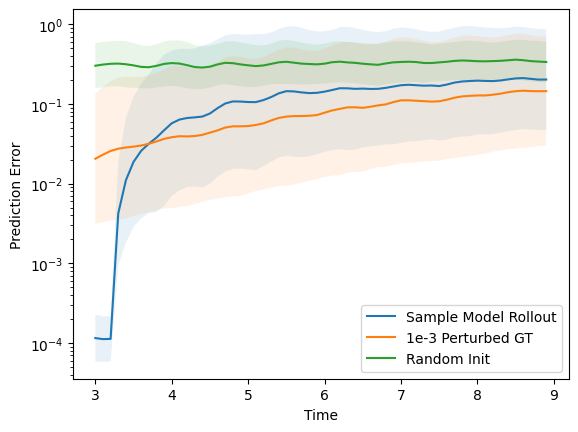

In [327]:
from jax import vmap
import train
import matplotlib.pyplot as plt
#
T = T_long
z1 = sde_samples
#z_gts = test_x[:z1.shape[0]]
#z0 = z_gts[:,0]#z_gts[:,0]


# z_pert = vmap(ds.integrate,(0,None),0)(z0+1e-3*np.random.randn(*z0.shape),T)
# z_random = vmap(ds.integrate,(0,None),0)(ds.sample_initial_conditions(z0.shape[0]),T)
for pred,label in zip([z1,z_pert,z_random],['Sample Model Rollout','1e-3 Perturbed GT','Random Init']):
    clamped_errs = jax.lax.clamp(1e-5,train.rel_err(pred,z_gt),np.inf)
    rel_errs = np.exp(jnp.log(clamped_errs).mean(0))
    rel_stds = np.exp(jnp.log(clamped_errs).std(0))
    plt.plot(T,rel_errs,label=label)
    plt.fill_between(T, rel_errs/rel_stds, rel_errs*rel_stds,alpha=.1)

plt.plot()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.legend()

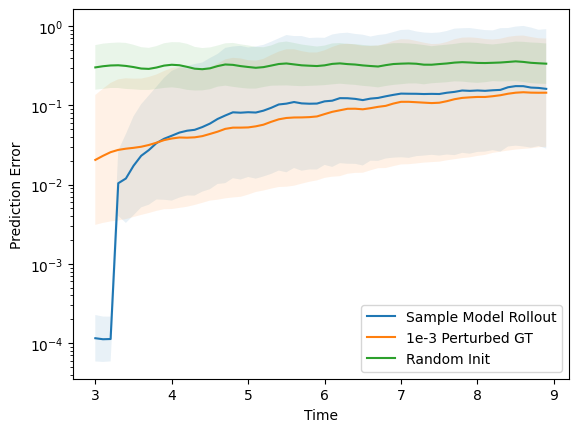

In [321]:
from jax import vmap
import train
import matplotlib.pyplot as plt
#
T = T_long
z1 = sde_samples
#z_gts = test_x[:z1.shape[0]]
#z0 = z_gts[:,0]#z_gts[:,0]


# z_pert = vmap(ds.integrate,(0,None),0)(z0+1e-3*np.random.randn(*z0.shape),T)
# z_random = vmap(ds.integrate,(0,None),0)(ds.sample_initial_conditions(z0.shape[0]),T)
for pred,label in zip([z1,z_pert,z_random],['Sample Model Rollout','1e-3 Perturbed GT','Random Init']):
    clamped_errs = jax.lax.clamp(1e-5,train.rel_err(pred,z_gt),np.inf)
    rel_errs = np.exp(jnp.log(clamped_errs).mean(0))
    rel_stds = np.exp(jnp.log(clamped_errs).std(0))
    plt.plot(T,rel_errs,label=label)
    plt.fill_between(T, rel_errs/rel_stds, rel_errs*rel_stds,alpha=.1)

plt.plot()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.legend()

In [296]:
expanded = (z_gt[None,::20]+jnp.zeros((20,1,1,1))).reshape(z_gt.shape)
if config.ic_conditioning:
    unc_score_fn = partial(score_fn,cond=cond_fn(expanded))
else:
    slc = slice(3)
    unc_score_fn = samplers.inpainting_scores(diff, score_fn, expanded[:,slc],slc,alpha=100.)
unc_score_fn = jit(unc_score_fn)

In [ ]:
predictions = samplers.sde_sample(diff, unc_score_fn , key, test_x.shape,nsteps=1000)

In [ ]:
preds = predictions.reshape(20,-1,*predictions.shape[1:])
upper = jnp.quantile(preds,.9,0)
lower = jnp.quantile(preds,.1,0)

In [ ]:
z_gt[:,0]

In [ ]:
z1[:,0]

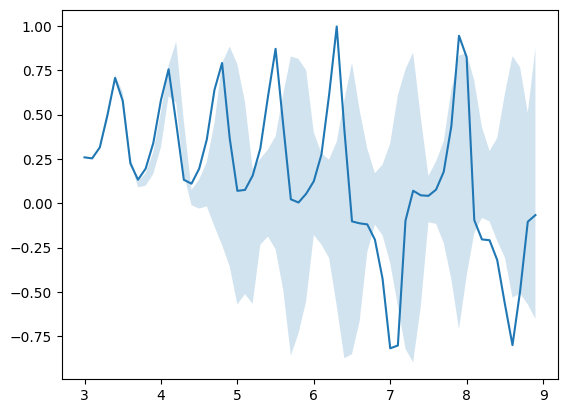

In [319]:
i=1
plt.fill_between(T_long,lower[i,:,1],upper[i,:,1],alpha=.2)
plt.plot(T_long,expanded[i,:,1])

In [304]:
q = .1+(np.arange(9))/10.
qs = jnp.quantile(preds,q,axis=0)

In [305]:
preds.shape

(20, 25, 60, 3)

In [306]:
q

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [307]:
preds[:,7,10,1]

DeviceArray([-0.46800432, -0.42810214, -0.6971764 , -0.652681  ,
             -0.66254234,  0.0288057 , -0.67901725, -0.6694731 ,
             -0.42840984, -0.5062284 , -0.45199922, -0.58225507,
             -0.62719566, -0.58022726, -0.74100107, -0.58867383,
             -0.36716098, -0.4010719 ,  0.0727914 , -0.57829076],            dtype=float32)

In [308]:
jnp.percentile(preds[:,7,10,1],q*100,axis=0)

DeviceArray([-0.68083316, -0.6639285 , -0.63484126, -0.5848226 ,
             -0.57925904, -0.49093878, -0.4449224 , -0.4226961 ,
             -0.32756418], dtype=float32)

In [309]:
flat_qs = qs.reshape(9,-1).T
flat_gts = z_gt[::20].reshape(-1)

In [310]:
qs.shape

(9, 25, 60, 3)

In [311]:
z_gt[::20].shape

(25, 60, 3)

In [372]:
bins = vmap(partial(jnp.digitize,right=True))(flat_gts,flat_qs)

In [373]:
binvals = jnp.stack([(bins.reshape(qs.shape[1:])<=i).mean(axis=(0,-1)) for i in range(10)],0)

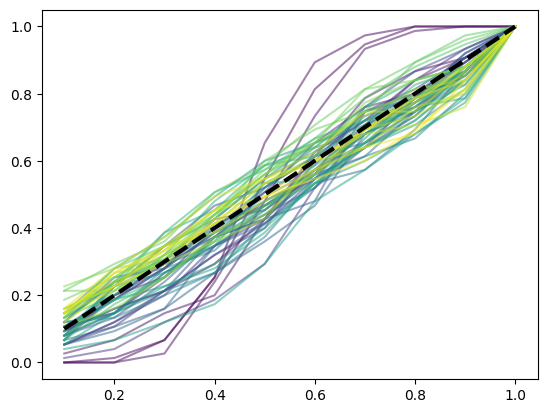

In [384]:
colors = plt.cm.viridis(np.linspace(0,1,binvals.shape[1]))
#plt.set_cmap('jet')
#plt.plot(np.arange(binvals.shape[0]),binvals)
for bval,c in zip(binvals.T[:],colors):
    plt.plot((1+np.arange(binvals.shape[0]))/10,bval,color=c,alpha=.5)
plt.plot((1+np.arange(binvals.shape[0]))/10,(1+np.arange(binvals.shape[0]))/10.,'--',lw=3,color='k')
#plt.colorbar()

In [376]:
binvals[-2]

DeviceArray([1.        , 1.        , 1.        , 0.9066667 , 0.9066667 ,
             0.8933334 , 0.85333335, 0.8933334 , 0.8666667 , 0.93333334,
             0.8666667 , 0.9066667 , 0.92      , 0.9066667 , 0.93333334,
             0.85333335, 0.8933334 , 0.9066667 , 0.8666667 , 0.92      ,
             0.8666667 , 0.88      , 0.84000003, 0.8666667 , 0.84000003,
             0.8666667 , 0.8       , 0.8666667 , 0.8666667 , 0.85333335,
             0.8266667 , 0.88      , 0.81333333, 0.7733334 , 0.7866667 ,
             0.8666667 , 0.7866667 , 0.88      , 0.88      , 0.8666667 ,
             0.84000003, 0.84000003, 0.8266667 , 0.9466667 , 0.97333336,
             0.96000004, 0.88      , 0.88      , 0.88      , 0.84000003,
             0.88      , 0.85333335, 0.8       , 0.81333333, 0.76      ,
             0.8666667 , 0.88      , 0.84000003, 0.84000003, 0.81333333],            dtype=float32)

(array([471., 364., 368., 479., 500., 506., 490., 363., 385., 574.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

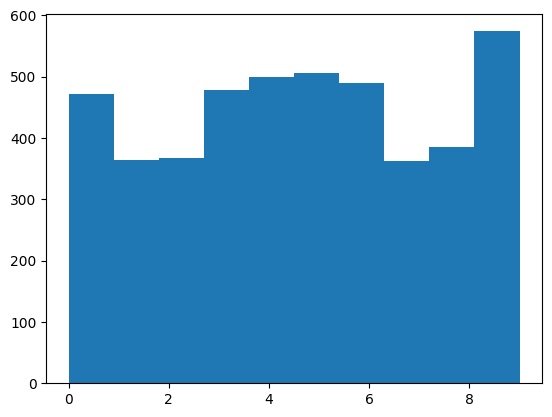

In [328]:
plt.hist(bins)

In [264]:
flat_qs[304]

DeviceArray([-0.6805058 , -0.6778368 , -0.67650515, -0.6732956 ,
             -0.6713885 , -0.6712076 , -0.6705958 , -0.6697186 ,
             -0.6690063 , -0.6558227 ], dtype=float32)

In [265]:
flat_gts[304]

DeviceArray(-0.6393552, dtype=float32)